# unified code for python file in backend

model.py

In [1]:
import numpy as np
import torch
import cv2
import lungs_finder as lf #pip install git+https://github.com/dirtmaxim/lungs-finder
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, rgba2rgb, gray2rgb

from albumentations.core.composition import *
from albumentations.pytorch import ToTensor, ToTensorV2
from albumentations.augmentations.transforms import *

threshold = 0.5

def normalizer(img, **params):
    img = img.astype(np.float32)
    if img.max()>255:
        img/=65535.
    elif img.max()>1:
        img/=255.
    return (img-0.5)*2

preprocess = Compose([Lambda(image=normalizer), Resize(224, 224), ToTensorV2()])

# ---------- HELPERS FOR VISUALIZATION
"""
gradcam wrapperg
"""
class GradCam:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.hooks = []
        self.fmap_pool = dict()
        self.grad_pool = dict()

        def forward_hook(module, input, output):
            self.fmap_pool[module] = output.detach().cpu()
        def backward_hook(module, grad_in, grad_out):
            self.grad_pool[module] = grad_out[0].detach().cpu()
        
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(forward_hook))
            self.hooks.append(layer.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)

    def get(self, layer):
        assert layer in self.layers, f'{layer} not in {self.layers}'
        fmap_b = self.fmap_pool[layer] # [N, C, fmpH, fmpW]
        grad_b = self.grad_pool[layer] # [N, C, fmpH, fmpW]

        grad_b = torch.nn.functional.adaptive_avg_pool2d(grad_b, (1, 1)) # [N, C, 1, 1]
        gcam_b = (fmap_b * grad_b).sum(dim=1, keepdim=True) # [N, 1, fmpH, fmpW]
        gcam_b = torch.nn.functional.relu(gcam_b)

        return gcam_b
    
"""
guidedbackprop wrapper
"""
class GuidedBackPropogation:
    def __init__(self, model):
        self.model = model
        self.hooks = []

        def backward_hook(module, grad_in, grad_out):
            if isinstance(module, torch.nn.ReLU):
                return tuple(grad.clamp(min=0.0) for grad in grad_in)

        for name, module in self.model.named_modules():
            self.hooks.append(module.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)
    
    def get(self, layer):
        return layer.grad.cpu()

"""
gradcam predictor (also returns model prediction)
"""
def get_grad(model,img, dsize=[224,224]):

    torch.set_grad_enabled(True)
    
    gcam = GradCam(model, [model.features])

    out = gcam(img)

    mask = (out>=threshold)[0]
    out[0:1, out[0].argmax()].sum().backward()

    grad = gcam.get(model.features)[0:1]
    grad = torch.nn.functional.interpolate(grad, dsize, mode='bilinear', align_corners=False)

    # we return everything only for 1 image
    return out[0], grad[0,0,:,:]

"""
guided backprop predictor
"""
def get_gbprop(model, img):

    torch.set_grad_enabled(True)
    
    gdbp = GuidedBackPropogation(model)
    inp_b = img.requires_grad_() # Enable recording inp_b's gradient
    out_b = gdbp(inp_b)
    mask = (out_b>=threshold)[0]
    out_b[0:1, out_b[0].argmax()].sum().backward()

    grad_b = gdbp.get(img)[0:1] # [N, 3, inpH, inpW]
    grad_b = grad_b.mean(dim=1, keepdim=True).abs() # [N, 1, inpH, inpW]
        
    return grad_b.squeeze()
    
def normalize(img):
    out = img-img.min()
    out/=(out.max()+1e-7)
    return out
    

# --------- END OF HELPERS FOR VISUALIZATION--------


# --------- model functions
    
def load_model(ckpt_path):
    """
    function us used to load our model from checkpoint and return it
    """
  
    from densenet import densenet121

    model = densenet121(num_classes=14)

    class Fixer(torch.nn.Module):
        def __init__(self, model):
            super(Fixer, self).__init__()
            self.model = model

    model = Fixer(model)
    model.load_state_dict(torch.load(ckpt_path)['state_dict'])
    model = model.model
    
    model.train()
    
    return model


def convert_prediction_to_pathology(y_pred, threshold = threshold):
    """
    this function is used to convert vector of anwers to vector of string representations
    e.g. [1,1,0,0,0,0,...] to ['Atelec...','Cadioomeg...']
    """
    pathologies = np.asarray(['Atelectasis',
                 'Cardiomegaly',
                 'Consolidation',
                 'Edema',
                 'Effusion',
                 'Emphysema',
                 'Fibrosis',
                 'Hernia',
                 'Infiltration',
                 'Mass',
                 'Nodule',
                 'Pleural_Thickening',
                 'Pneumonia',
                 'Pneumothorax'])
    
    y_pred = y_pred.clone().detach().cpu().numpy()
    mask = (y_pred>=threshold).astype(bool)
    
    return pathologies[mask].tolist()

def prepare_image(path_to_image):
    """
    image preprocessor
    
    Args:
        path_to_image: string with image location
    """
    image = cv2.imread(path_to_image).astype(float)
    
    if image.ndim==3:
        if image.shape[2]==4:
            image = rgb2gray(rgba2rgb(image))
        else:
            image = rgb2gray(image)
    image = np.expand_dims(image,-1)
    
    image = preprocess(image=image)['image'].unsqueeze(0)
    return image

def predict_visual(model, path_to_image, isCuda = False):
    """
    function is used to predict labels and visualise image
    
    Args:
        path_to_image: str with image location (0-255)
        model: our loaded model
        isCuda: bool flag, set to Treu to run on gpu
    """
    # sadly, gbrop can not be extract at the same time as gradcam
    # so we have to do two predictions for the same image
    image = prepare_image(path_to_image)
    
    if isCuda:
        image = image.to(torch.device('cuda'))
        model.to(torch.device('cuda'))
    
    image.require_grad = True
    pred, gcam = get_grad(model, image)
    gbprop = get_gbprop(model, image)
    
    # plt.imshow((np.repeat(normalize(img.squeeze().detach().cpu().numpy())[:,:,np.newaxis],3,2)+plt.cm.hot(normalize(gbprop*grad).detach().cpu().numpy())[:,:,:3])/2)
    visualization = normalize((gbprop*gcam).detach().cpu().numpy())
    visualization = normalize(visualization)
    
    orig = (normalize(image.detach().cpu().numpy()[0,0,:,:])*255).astype(np.uint8)

    visualization = plt.get_cmap('hot')(visualization)[:,:,:3]

    final = np.zeros(visualization.shape)
    right_lung_haar_rectangle = lf.find_right_lung_haar(orig)
    left_lung_haar_rectangle = lf.find_left_lung_haar(orig)

    if (right_lung_haar_rectangle is not None) and (left_lung_haar_rectangle is not None):
        x, y, width, height = right_lung_haar_rectangle
        final[y:y + height, x:x + width] = visualization[y:y + height, x:x + width]
        x, y, width, height = left_lung_haar_rectangle
        final[y:y + height, x:x + width] = visualization[y:y + height, x:x + width]
    else:
        final = visualization

    final = normalize(final + \
        cv2.cvtColor(orig, cv2.COLOR_GRAY2RGB).astype(
            np.float32)/255)
    
    return pred, final

def predict(model, path_to_image, isCuda = False):
    """
    used to predit labels only (to speed up the process)
    isCuda: bool flag, set to Treu to run on gpu
    """
    image = prepare_image(path_to_image)
    
    if isCuda:
        image = image.to(torch.device('cuda'))
        model.to(torch.device('cuda'))
    
    return model(image)[0]  

In [2]:
model = load_model("./densenet121nobn.ckpt")
model.train()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): Identity()
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): Identity()
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): Identity()
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): Identity()
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): Identity()
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      

In [3]:

pred, vis = predict_visual(model,"/home/alexander/work/hackathon/chest-14/images/00014022_084.png") # cardiomegaly
pred

tensor([1.7246e-18, 9.9999e-01, 1.5775e-13, 5.4511e-20, 1.4000e-06, 7.5157e-26,
        2.3458e-08, 5.2977e-20, 1.2949e-08, 3.1674e-08, 5.8204e-08, 3.1360e-05,
        4.7115e-19, 1.4685e-15], grad_fn=<SelectBackward>)

In [4]:
vis

array([[[0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        ...,
        [0.04403379, 0.01750548, 0.01750548],
        [0.04403379, 0.01750548, 0.01750548],
        [0.04403379, 0.01750548, 0.01750548]],

       [[0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        ...,
        [0.04403379, 0.01750548, 0.01750548],
        [0.04403379, 0.01750548, 0.01750548],
        [0.04403379, 0.01750548, 0.01750548]],

       [[0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        [0.04153301, 0.0150047 , 0.0150047 ],
        ...,
        [0.04403379, 0.01750548, 0.01750548],
        [0.04153301, 0.0150047 , 0.0150047 ],
        [0.04403379, 0.01750548, 0.01750548]],

       ...,

       [[0.32162075, 0.29509244, 0.29509244],
        [0.31661918, 0.29009087, 0.29009087],
        [0.3141184 , 0

In [5]:
model.train()
pred = predict(model,"/home/alexander/work/hackathon/chest-14/images/00014022_084.png")
pred

tensor([1.7246e-18, 9.9999e-01, 1.5775e-13, 5.4511e-20, 1.4000e-06, 7.5157e-26,
        2.3458e-08, 5.2977e-20, 1.2949e-08, 3.1674e-08, 5.8204e-08, 3.1360e-05,
        4.7115e-19, 1.4685e-15], grad_fn=<SelectBackward>)

In [6]:
convert_prediction_to_pathology(pred)

['Cardiomegaly']

In [7]:
vis.max()

0.9999999362300245

In [8]:
import matplotlib.pyplot as plt

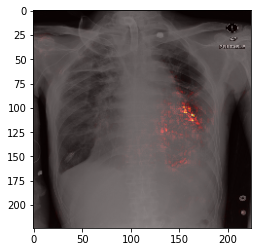

In [9]:
plt.imshow(vis)

# test prediction on 32 images

In [10]:
import pandas as pd
df_only_labels = pd.read_csv('/home/alexander/work/hackathon/chest-14/Data_Entry_2017.csv')
df_only_labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [11]:
# import matplotlib.pyplot as plt
# for i, img in df_only_labels.iterrows():
#     pred, vis = predict_visual(model,'/home/alexander/work/hackathon/chest-14/images/'+img['Image Index'], isCuda=True) 
#     print(f"True: {img['Finding Labels']} ; Pred: {convert_prediction_to_pathology(pred)}")
#     plt.imshow(vis)
#     plt.show()

here starts the magic

In [12]:
import PIL
import datetime
from time import sleep
import os
from os import listdir as ls
from tqdm import tqdm
import pytz

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, transform

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import albumentations as A
from albumentations.pytorch import ToTensor

from torch.utils.tensorboard import SummaryWriter

from scipy.special import expit
import sklearn
from pprint import pprint

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import re

preprocess_semyon = A.Compose([A.Resize(256, 256),
    A.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    ),
    ToTensor()
    ])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def new_densenet121(imagenet=True, path_to_weights=None):
    net = torchvision.models.densenet121()
    if imagenet:        
        state_dict = torch.load('../weights/misc/densenet121_pretrained.pth')
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key] 
        net.load_state_dict(state_dict)
        num_ftrs = net.classifier.in_features
        net.classifier = nn.Linear(num_ftrs, 14)
    else:
        if path_to_weights == None:
            num_ftrs = net.classifier.in_features
            net.classifier = nn.Linear(num_ftrs, 14)
        else:
            state_dict = torch.load(path_to_weights)
            num_ftrs = net.classifier.in_features
            net.classifier = nn.Linear(num_ftrs, 14)
            net.load_state_dict(state_dict)
    return net.to(device)


def new_inceptionV3(imagenet=True, path_to_weights=None):
    net = torchvision.models.inception_v3()
    if imagenet:        
        state_dict = torch.load('../weights/misc/inception_v3_pretrained_imagenet.pth')
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key] 
        net.load_state_dict(state_dict)
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, 14)
    else:
        if path_to_weights == None:
            num_ftrs = net.fc.in_features
            net.fc = nn.Linear(num_ftrs, 14)
        else:
            state_dict = torch.load(path_to_weights)
            num_ftrs = net.fc.in_features
            net.fc = nn.Linear(num_ftrs, 14)
            net.load_state_dict(state_dict)
    net.aux_logits = False
    return net.to(device)

def prepare_image_semyon(path_to_image):
    """
    image preprocessor
    
    Args:
        path_to_image: string with image location
    """
    image = cv2.imread(path_to_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_semyon(image=image)['image'].unsqueeze(0)
    return image

def load_model_semyon(path): #'./lungs_disease_classification/weights/DenseNet121_FocalLoss_40epochs/densenet121_FocalLoss_fold4_epoch39.pth'
    model = new_densenet121(False,path_to_weights=path)
    model.classifier = torch.nn.Sequential(model.classifier, torch.nn.Sigmoid())
    return model

def predict_semyon(model, path_to_image, isCuda = False):
    """
    used to predit labels only (to speed up the process)
    isCuda: bool flag, set to Treu to run on gpu
    """
    image = prepare_image_semyon(path_to_image)

    image = image.to(device)
    model.to(device)
    
    model.eval()
    
    return model(image)[0]

def predict_visual_semyon(model, path_to_image, isCuda = False):
    """
    function is used to predict labels and visualise image
    
    Args:
        path_to_image: str with image location (0-255)
        model: our loaded model
        isCuda: bool flag, set to Treu to run on gpu
    """
    # sadly, gbrop can not be extract at the same time as gradcam
    # so we have to do two predictions for the same image
    image = prepare_image_semyon(path_to_image)
    
    image = image.to(device)
    model.to(device)
    model.eval()

    image.require_grad = True
    pred, gcam = get_grad(model, image, dsize=[256,256])
    
    # plt.imshow((np.repeat(normalize(img.squeeze().detach().cpu().numpy())[:,:,np.newaxis],3,2)+plt.cm.hot(normalize(gbprop*grad).detach().cpu().numpy())[:,:,:3])/2)
    visualization = normalize((gcam).detach().cpu().numpy())
    visualization = normalize(visualization)
    
    orig = (normalize(image.detach().cpu().numpy()[0,0,:,:])*255).astype(np.uint8)

    visualization = plt.get_cmap('hot')(visualization)[:,:,:3]

    final = np.zeros(visualization.shape)
    right_lung_haar_rectangle = lf.find_right_lung_haar(orig)
    left_lung_haar_rectangle = lf.find_left_lung_haar(orig)

    if (right_lung_haar_rectangle is not None) and (left_lung_haar_rectangle is not None):
        x, y, width, height = right_lung_haar_rectangle
        final[y:y + height, x:x + width] = visualization[y:y + height, x:x + width]
        x, y, width, height = left_lung_haar_rectangle
        final[y:y + height, x:x + width] = visualization[y:y + height, x:x + width]
    else:
        final = visualization

    final = normalize(final + \
        cv2.cvtColor(orig, cv2.COLOR_GRAY2RGB).astype(
            np.float32)/255)
    
    return pred, final

In [13]:
model = load_model_semyon('./lungs_disease_classification/weights/DenseNet121_BCE_30epochs/densenet_fold2_epoch29.pth')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
pred = predict_semyon(model,"/home/alexander/work/hackathon/chest-14/images/00014022_084.png")
pred

tensor([2.1960e-01, 1.5525e-02, 5.6489e-01, 3.5428e-01, 1.0251e-01, 2.3110e-01,
        1.3093e-02, 7.1243e-02, 7.8208e-02, 2.0847e-03, 1.0214e-01, 1.1252e-01,
        2.4639e-01, 1.8154e-04], device='cuda:0', grad_fn=<SelectBackward>)

In [15]:
convert_prediction_to_pathology(torch.nn.functional.sigmoid(pred))

/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [16]:
import pandas as pd
df_only_labels = pd.read_csv('/home/alexander/work/hackathon/chest-14/Data_Entry_2017.csv')

pathologies = ['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']


labels = []
for pathology in pathologies:
    labels.append(df_only_labels['Finding Labels'].str.contains(pathology).values)

labels = np.asarray(labels).T
labels = labels.astype(int)

labels


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
vis.max()
vis.min()

0.0

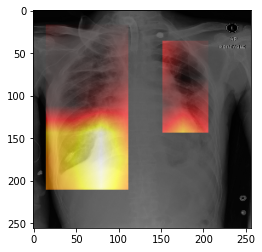

In [17]:
pred, vis = predict_visual_semyon(model,"/home/alexander/work/hackathon/chest-14/images/00014022_084.png")

plt.imshow(vis)

In [18]:
import matplotlib.pyplot as plt
from tqdm import tqdm

y_true = []
y_pred = []

for i, img in tqdm(df_only_labels.iterrows()):
#     pred, vis = predict_visual_semyon(model,'/home/alexander/work/hackathon/chest-14/images/'+img['Image Index'], isCuda=True) 
#     print(f"True: {img['Finding Labels']} ; Pred: {convert_prediction_to_pathology(pred)}")
#     print(pred)
#     plt.imshow(vis)
#     plt.show()
    y_pred.append(predict_semyon(model,'/home/alexander/work/hackathon/chest-14/images/'+img['Image Index'], isCuda=True).detach().cpu().numpy())
    y_true.append(labels[i])

56990it [1:10:04, 13.56it/s]


KeyboardInterrupt: 

In [ ]:
y_pred